In [1]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pandas as pd
import numpy as np

# Training dataset
train_df = pd.read_csv(
    r"D:\ML Data\twitter_training.csv\twitter_data.csv",
    header=None,
    names=["ID", "Topic", "Sentiment", "Text"]
)

# Validation dataset (change path if you have a separate file)
valid_df = pd.read_csv(
    r"D:\ML Data\twitter_training.csv\twitter_data.csv",
    header=None,
    names=["ID", "Topic", "Sentiment", "Text"]
)

print("Training Data Sample:")
print(train_df.head())

print("\nValidation Data Sample:")
print(valid_df.head())

Training Data Sample:
     ID        Topic Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                Text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

Validation Data Sample:
     ID        Topic Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                Text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [12]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [15]:
print(train_df.describe())
print(valid_df.describe())

                 ID
count  74682.000000
mean    6432.586165
std     3740.427870
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000
                 ID
count  74682.000000
mean    6432.586165
std     3740.427870
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000


Preprocessing
In this step, we clean the raw tweet texts to make them suitable for analysis.The preprocessing pipeline includes: 
1- Converting text to lowercase
2- Removing URLs, mentions, hashtags, punctuation, and special characters
3- Tokenization (splitting sentences into words)
4- Stopword removal (removing common words like "the", "is", "at")
5- Lemmatization (converting words to their base form, e.g., "running" → "run")

This ensures that the machine learning model focuses only on meaningful information.

In [17]:
import re
import html
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# download resources 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# stopwords & lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)                 # decode HTML
    text = text.lower()                        # lowercase
    text = re.sub(r'http\S+|www\.\S+', ' ', text)   # remove urls
    text = re.sub(r'@\w+', ' ', text)          # remove mentions
    text = re.sub(r'#', ' ', text)             # remove hash only
    text = re.sub(r'[^a-z0-9\s]', ' ', text)   # keep alnum + spaces
    tokens = nltk.word_tokenize(text)          # tokenize
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]  # lemmatize
    return " ".join(tokens)

# apply on both datasets
train_df['clean_text'] = train_df['Text'].apply(clean_text)
valid_df['clean_text'] = valid_df['Text'].apply(clean_text)

# check sample
print(train_df[['Text','clean_text']].head(10))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                                Text  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   
5  im getting into borderlands and i can murder y...   
6  So I spent a few hours making something for fu...   
7  So I spent a couple of hours doing something f...   
8  So I spent a few hours doing something for fun...   
9  So I spent a few hours making something for fu...   

                                          clean_text  
0                       im getting borderland murder  
1                                 coming border kill  
2                         im getting borderland kill  
3                        im coming borderland murder  
4                       im getting borderland murder  
5                       im getting borderland murder 

Encode labels

In [18]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#  Label encoding, fit on combined labels to ensure consistent mapping
le = LabelEncoder()
le.fit(pd.concat([train_df['Sentiment'], valid_df['Sentiment']], axis=0))
train_df['label_enc'] = le.transform(train_df['Sentiment'])
valid_df['label_enc'] = le.transform(valid_df['Sentiment'])
print("Label mapping (index -> label):", dict(enumerate(le.classes_)))

# Show class distribution
print("\nTrain_df class counts:\n", train_df['Sentiment'].value_counts())
print("\nValid_df class counts:\n", valid_df['Sentiment'].value_counts())

Label mapping (index -> label): {0: 'Irrelevant', 1: 'Negative', 2: 'Neutral', 3: 'Positive'}

Train_df class counts:
 Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

Valid_df class counts:
 Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


TF-IDF Vectorization

In [21]:
tfv = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_train = tfv.fit_transform(train_df['clean_text'])
X_valid = tfv.transform(valid_df['clean_text'])
y_train = train_df['label_enc']
y_valid = valid_df['label_enc']

print("\nTF-IDF matrix shapes, X_train, X_valid:", X_train.shape, X_valid.shape)


TF-IDF matrix shapes, X_train, X_valid: (74682, 10000) (74682, 10000)


 Compare Multiple Models

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# Convert results to DataFrame for easy plotting
res_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])

Logistic Regression Accuracy: 0.8008
Naive Bayes Accuracy: 0.7178
Decision Tree Accuracy: 0.9541
Random Forest Accuracy: 0.9541
Linear SVM Accuracy: 0.8549


Visualization

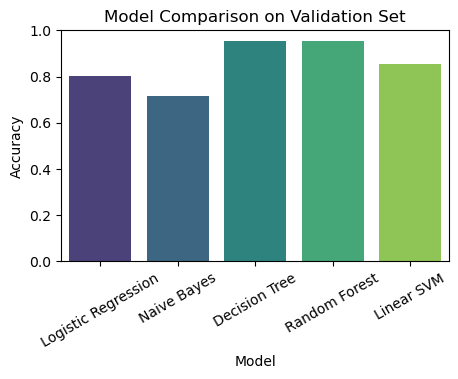

In [24]:
plt.figure(figsize=(5,3))
sns.barplot(x="Model", y="Accuracy", data=res_df, palette="viridis")
plt.title("Model Comparison on Validation Set")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()

Evaluation


Logistic Regression Accuracy: 0.8008
              precision    recall  f1-score   support

  Irrelevant       0.84      0.68      0.75     12990
    Negative       0.77      0.89      0.82     22542
     Neutral       0.82      0.76      0.79     18318
    Positive       0.80      0.82      0.81     20832

    accuracy                           0.80     74682
   macro avg       0.81      0.79      0.79     74682
weighted avg       0.80      0.80      0.80     74682

Confusion Matrix for Logistic Regression:


<Figure size 500x300 with 0 Axes>

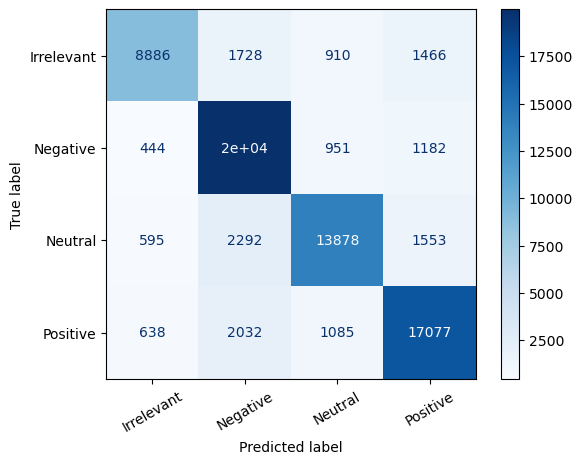

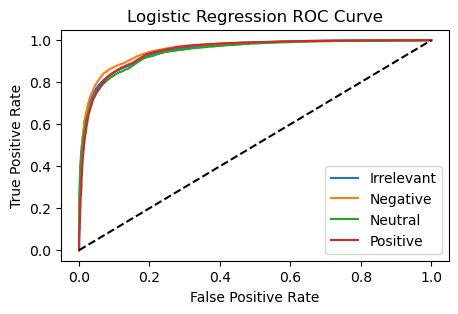


Naive Bayes Accuracy: 0.7178
              precision    recall  f1-score   support

  Irrelevant       0.84      0.50      0.63     12990
    Negative       0.67      0.86      0.76     22542
     Neutral       0.77      0.62      0.68     18318
    Positive       0.70      0.79      0.74     20832

    accuracy                           0.72     74682
   macro avg       0.75      0.69      0.70     74682
weighted avg       0.73      0.72      0.71     74682

Confusion Matrix for Naive Bayes:


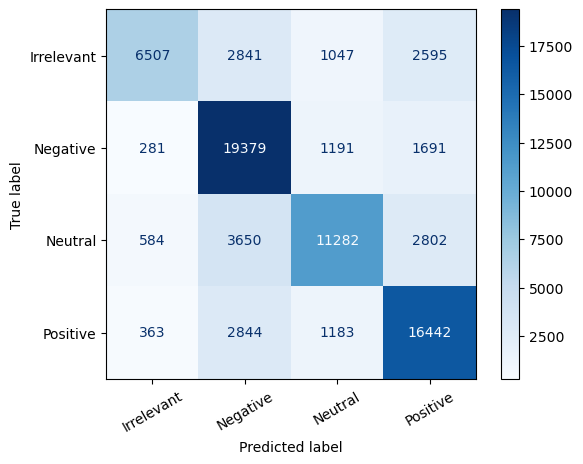

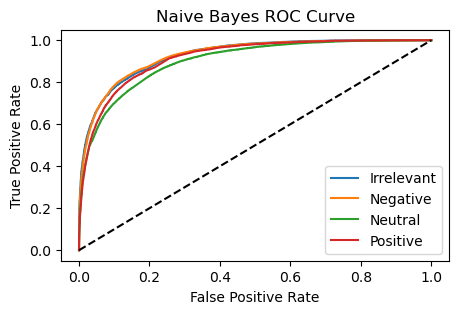


Decision Tree Accuracy: 0.9541
              precision    recall  f1-score   support

  Irrelevant       0.98      0.94      0.96     12990
    Negative       0.99      0.95      0.97     22542
     Neutral       0.98      0.94      0.96     18318
    Positive       0.89      0.98      0.93     20832

    accuracy                           0.95     74682
   macro avg       0.96      0.95      0.95     74682
weighted avg       0.96      0.95      0.95     74682

Confusion Matrix for Decision Tree:


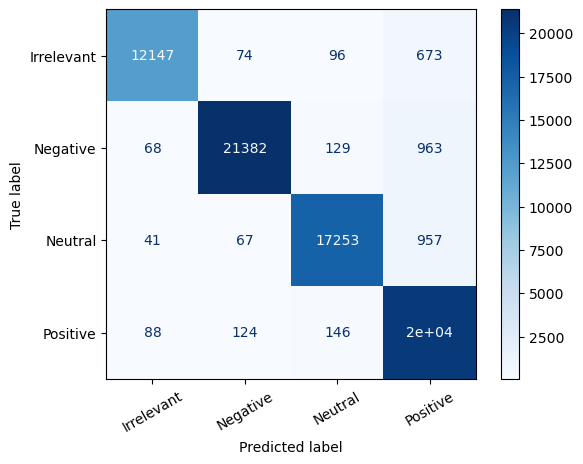

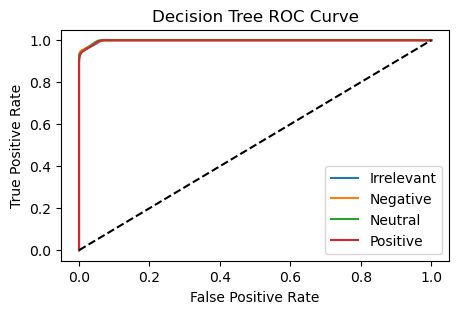


Random Forest Accuracy: 0.9541
              precision    recall  f1-score   support

  Irrelevant       0.99      0.93      0.96     12990
    Negative       0.99      0.95      0.97     22542
     Neutral       0.98      0.94      0.96     18318
    Positive       0.88      0.99      0.93     20832

    accuracy                           0.95     74682
   macro avg       0.96      0.95      0.95     74682
weighted avg       0.96      0.95      0.95     74682

Confusion Matrix for Random Forest:


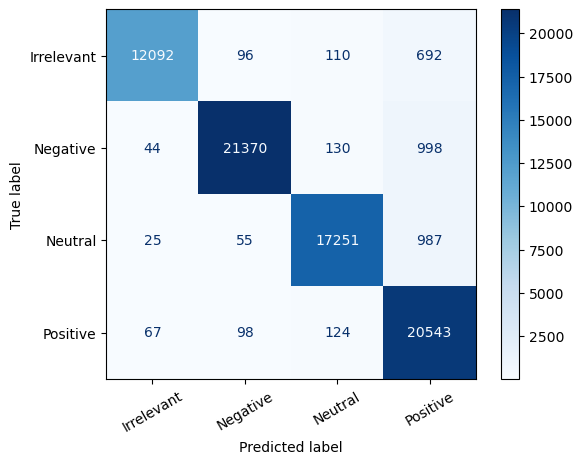

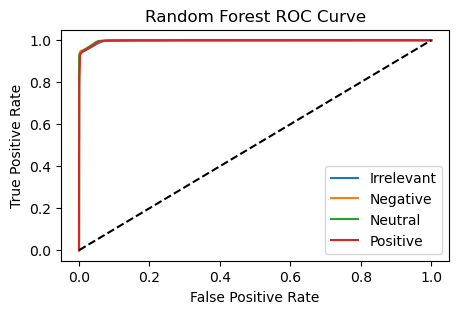


Linear SVM Accuracy: 0.8549
              precision    recall  f1-score   support

  Irrelevant       0.89      0.78      0.83     12990
    Negative       0.82      0.92      0.86     22542
     Neutral       0.88      0.83      0.86     18318
    Positive       0.86      0.86      0.86     20832

    accuracy                           0.85     74682
   macro avg       0.86      0.85      0.85     74682
weighted avg       0.86      0.85      0.85     74682

Confusion Matrix for Linear SVM:


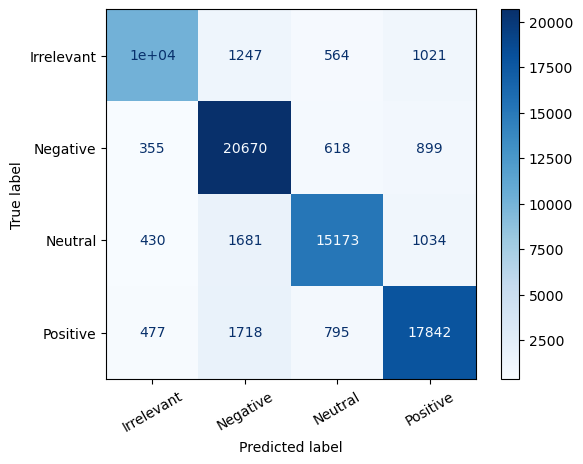

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC
y_valid_bin = label_binarize(y_valid, classes=range(len(le.classes_)))
n_classes = y_valid_bin.shape[1]

plt.figure(figsize=(5, 3))

for idx, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # Accuracy
    acc = accuracy_score(y_valid, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")

    # Classification report
    print(classification_report(y_valid, y_pred, target_names=le.classes_))
    
    # Confusion matrix
    print(f"Confusion Matrix for {name}:")
    disp = ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid,
                                                 display_labels=le.classes_,
                                                 cmap='Blues',
                                                 xticks_rotation=30)
    
    
    # ROC curve for multiclass
    y_score = model.predict_proba(X_valid) if hasattr(model, "predict_proba") else None
    if y_score is not None:
        plt.figure(figsize=(5,3))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_valid_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"{le.classes_[i]}")
        plt.plot([0,1], [0,1], 'k--')
        plt.title(f"{name} ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

Final Model:

 we choose Random Forest as final model because The Random Forest classifier showed high performance for tweet sentiment analysis, achieving the best accuracy among applied models.